In [146]:
import os
import sys
import json
import pprint #pretty print
import glob
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
print sys.version
print "Pandas: ",pd.version.version
from __future__ import division
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
#np.random.seed(125)

2.7.10 |Anaconda 2.3.0 (64-bit)| (default, May 28 2015, 16:44:52) [MSC v.1500 64 bit (AMD64)]
Pandas:  0.16.2


In [119]:
#####################################
# READ DATA
#####################################

bank_telemarket_df=pd.read_csv("C:/Users/xtl476/BigDataAcadBootCamp/Metis/Metis_Project_2/data/bank/bank.csv",sep=';')

#Change the name of the y column to Response
bank_telemarket_df=bank_telemarket_df.rename(columns = {'y':'Response'})

In [120]:
####################################################################################
#Data Type and Sanity Checks
####################################################################################
#Check for null values in movies dataframe
print "Number of rows which are Null by Column Names:\n"
print "\n",len(bank_telemarket_df.index)-bank_telemarket_df.count(),"\n"

Number of rows which are Null by Column Names:


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Response     0
dtype: int64 



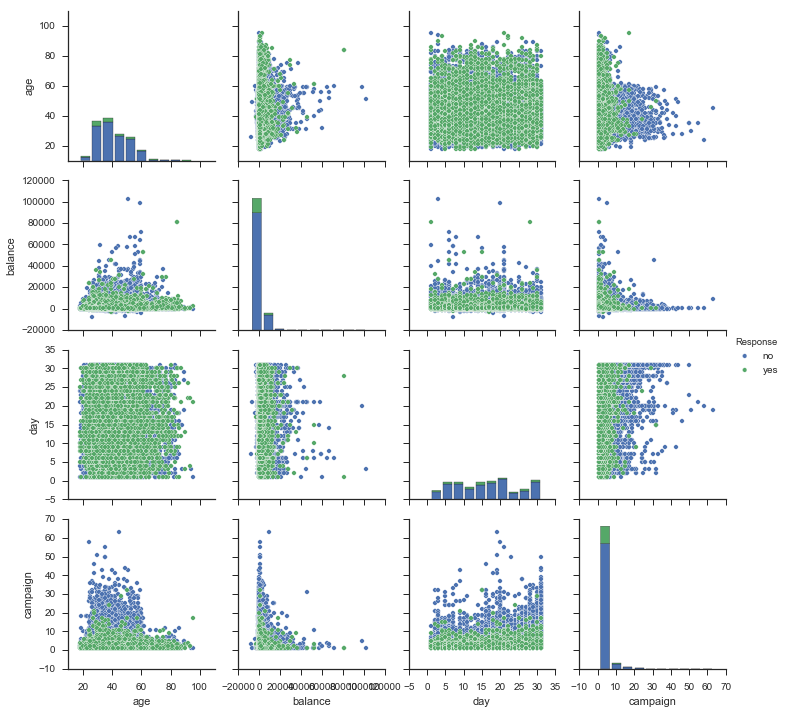

In [121]:
####################################################################################
##Create Pair Plots to assess Interactions
####################################################################################

import seaborn as sns; sns.set(style="ticks", color_codes=True)
bank_pairplot_df=bank_telemarket_df[['age','balance','day','campaign','Response']]
sns.pairplot(bank_pairplot_df,hue='Response')

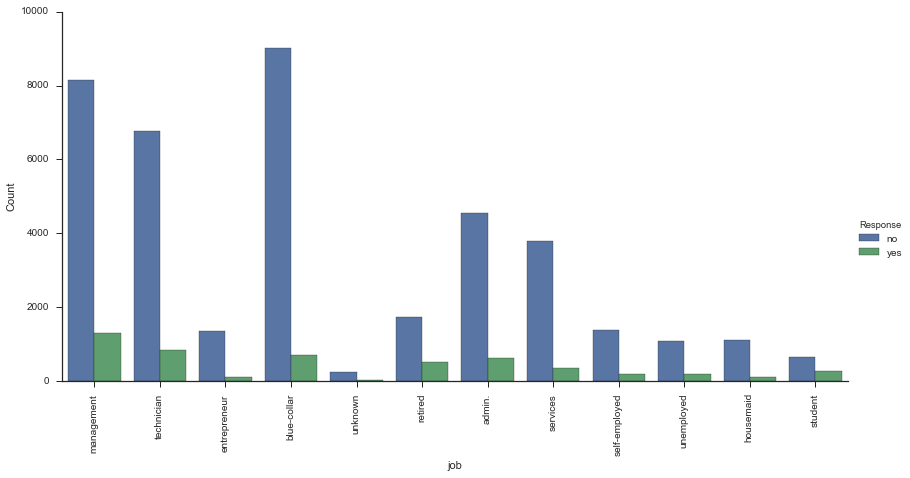

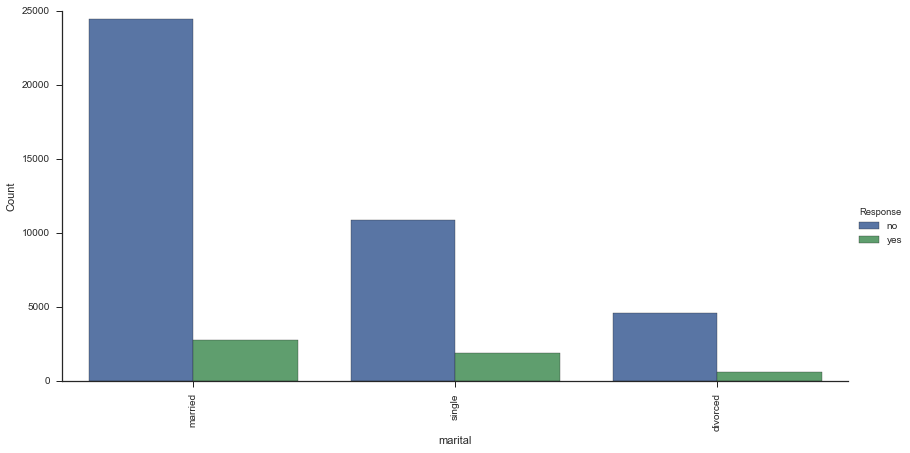

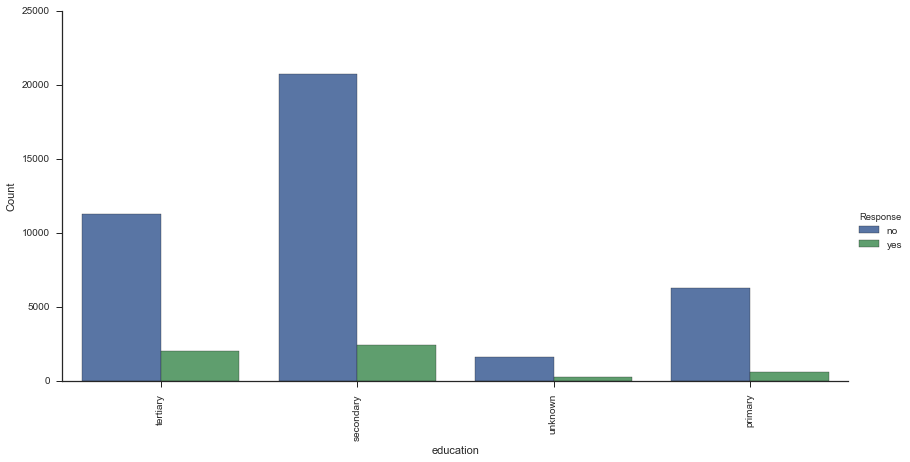

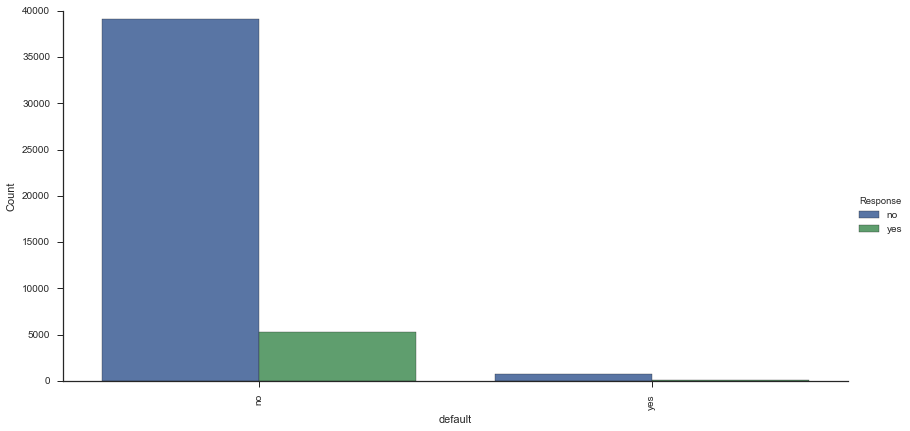

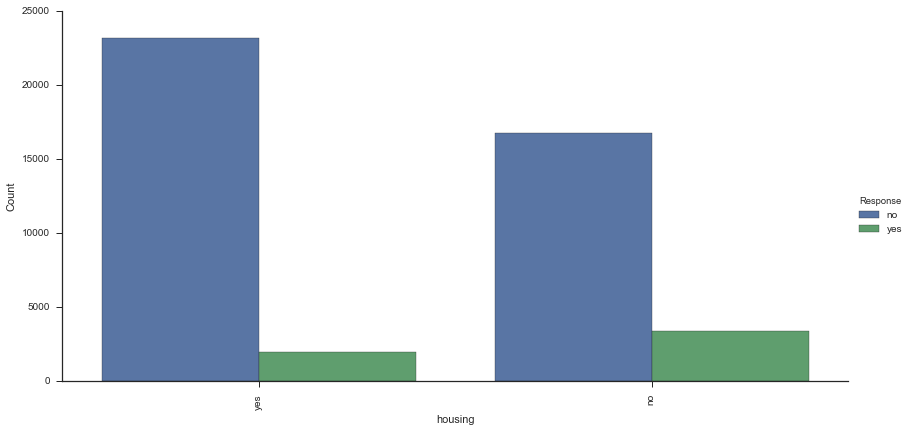

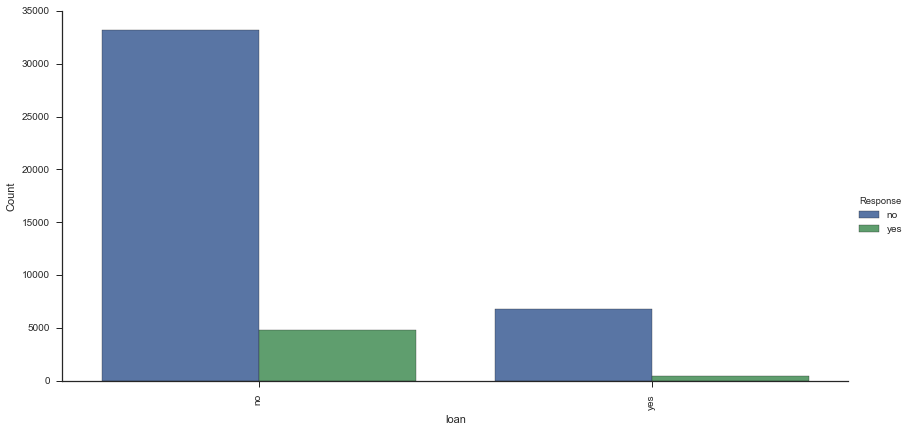

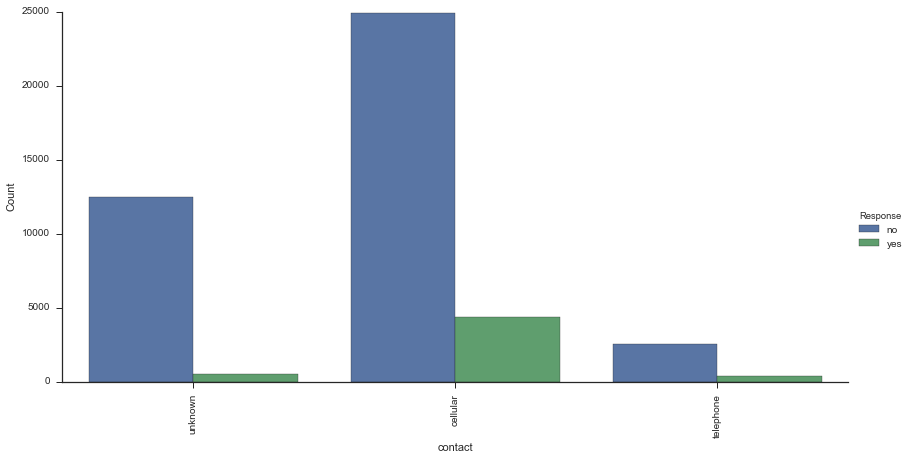

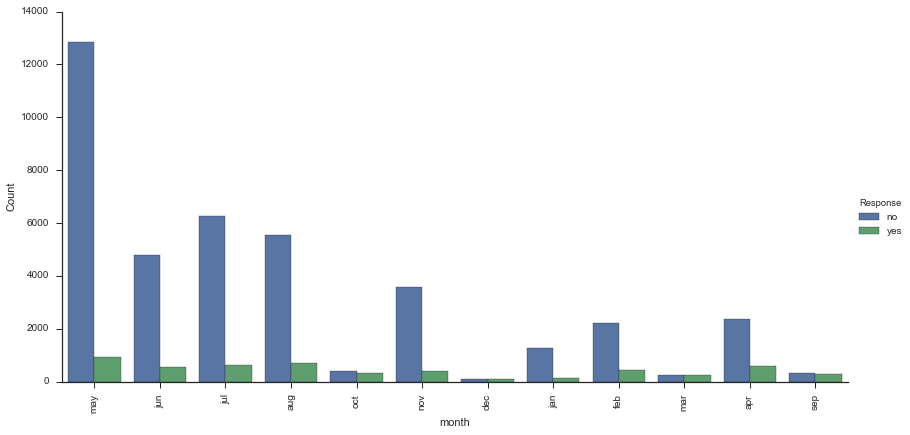

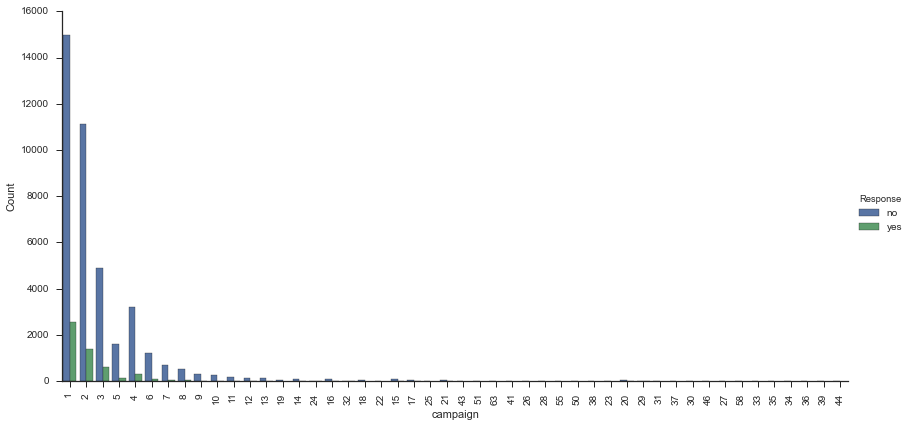

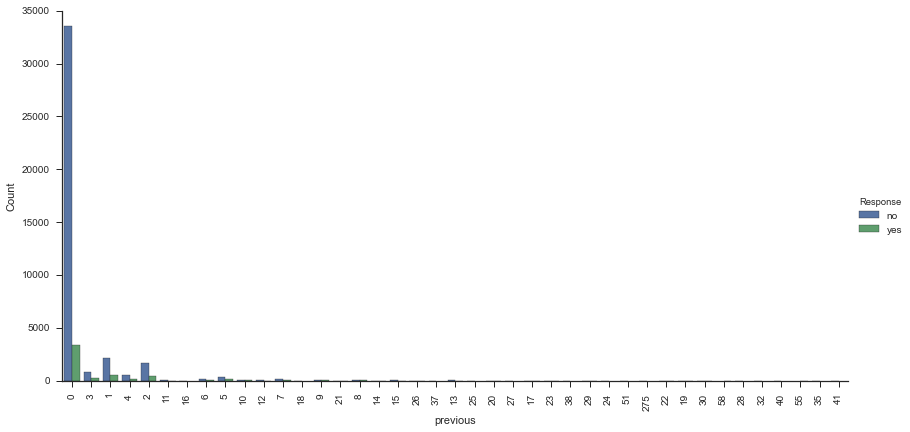

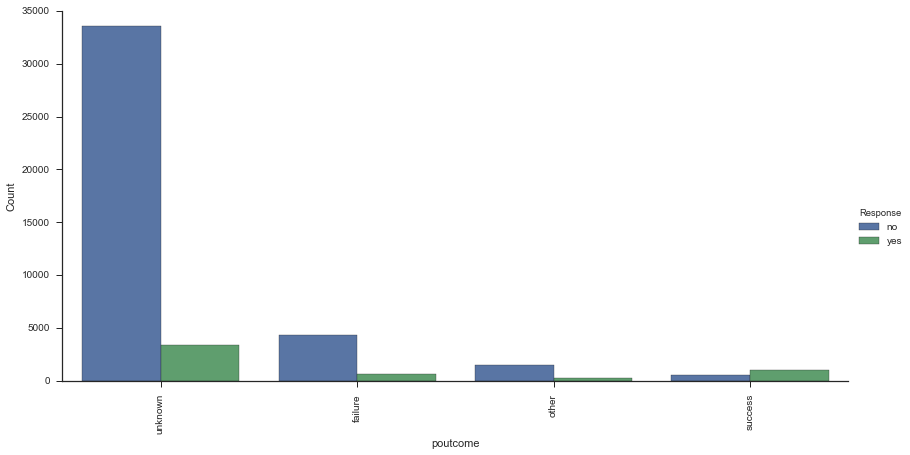

In [122]:
####################################################################################
##Create Bar Charts by Response for Categorical Variables
####################################################################################


#bank_telemarket_df['Response'].replace(['yes','no'], [1,0], inplace=True)
bank_telemarket_for_plots_df=bank_telemarket_df.copy()
bank_telemarket_for_plots_df['Count'] =1
#print bank_telemarket_for_plots_df.columns
#print bank_telemarket_df.columns

list_of_features = ['job','marital','education','default','housing','loan','contact','month','campaign','previous','poutcome']
for i in list_of_features:
    xlabels=bank_telemarket_for_plots_df[i].unique()
    ax = sns.factorplot(x=i,y='Count',hue="Response",data=bank_telemarket_for_plots_df,estimator=np.sum,kind='bar',size=6,aspect=2)
    ax.set_xticklabels(xlabels,rotation=90)

In [123]:
####################################################################################
##Create Groups for key Continuous Variables
####################################################################################

def balance_group(row):
    if row['balance'] < 0:
        return 'negative_balance'
    elif row['balance'] <= 2500:
        return 'le_2500_balance'
    elif row['balance'] >2500:
        return 'gt_2500_balance'

bank_telemarket_df['balance_group'] = bank_telemarket_df.apply(lambda row: balance_group(row), axis=1)

def pdays_group(row):
#    if row['pdays'] == -1:
#        return 'no_previous_contact'
#    else:
#        return 'contacted_before'
    if row['pdays'] == -1:
        return 'no_previous_contact'
    if row['pdays'] <=200:
        return 'contacted_last_200_days'
    elif row['pdays'] >200:
        return 'not_contacted_last_200_days'

bank_telemarket_df['pdays_group'] = bank_telemarket_df.apply(lambda row: pdays_group(row), axis = 1)

def campaign_group(row):
    if row['campaign'] <= 0:
        return 'No_Contact_campaign'
    elif row['campaign'] == 1:
        return '1_contact_campaign'
    elif row['campaign'] == 2:
        return '2_contacts_campaign'
    elif row['campaign'] > 2:
        return 'gt_2_contacts_campaign'

bank_telemarket_df['campaign_group'] = bank_telemarket_df.apply(lambda row: campaign_group(row), axis = 1)

def day_group(row):
    if 2 < row['day'] <= 8:
        return 'begining of month'
    elif row['day'] <= 16:
        return 'early to middle of month'
    elif row['day'] <=21:
        return 'middle to late of month'
    elif 21 < row['day'] <= 31:
        return 'end of month'

bank_telemarket_df['day_group'] = bank_telemarket_df.apply(lambda row: day_group(row), axis=1)



In [124]:
#bank_telemarket_df.head()

In [125]:
#pd.get_dummies(bank_telemarket_df.job).columns

In [126]:
bank_telemarket_df.columns

Index([u'age', u'job', u'marital', u'education', u'default', u'balance',
       u'housing', u'loan', u'contact', u'day', u'month', u'duration',
       u'campaign', u'pdays', u'previous', u'poutcome', u'Response',
       u'balance_group', u'pdays_group', u'campaign_group', u'day_group'],
      dtype='object')

In [127]:
#Add Dummies Column for default
dummies_default = pd.get_dummies(bank_telemarket_df['default'])
bank_telemarket_df = pd.concat([bank_telemarket_df,dummies_default],axis=1)
bank_telemarket_df=bank_telemarket_df.rename(columns = {'yes':'Default_yes'})
bank_telemarket_df=bank_telemarket_df.rename(columns = {'no':'Default_no'})


#Add Dummies Column for marital
dummies_marital = pd.get_dummies(bank_telemarket_df['marital'])
bank_telemarket_df = pd.concat([bank_telemarket_df,dummies_marital],axis=1)
#bank_telemarket_df=bank_telemarket_df.rename(columns = {'yes':'Default_yes'})
#bank_telemarket_df=bank_telemarket_df.rename(columns = {'no':'Default_no'})

#Add Dummies Column for month
dummies_month = pd.get_dummies(bank_telemarket_df['month'])
bank_telemarket_df = pd.concat([bank_telemarket_df,dummies_month],axis=1)

#Add Dummies Column for education
dummies_edu = pd.get_dummies(bank_telemarket_df['education'])
bank_telemarket_df = pd.concat([bank_telemarket_df,dummies_edu],axis=1)
bank_telemarket_df=bank_telemarket_df.rename(columns = {'unknown':'Education_unknown'})


#Add Dummies Column for housing
dummies_housing = pd.get_dummies(bank_telemarket_df['housing'])
bank_telemarket_df = pd.concat([bank_telemarket_df,dummies_housing],axis=1)
bank_telemarket_df=bank_telemarket_df.rename(columns = {'yes':'Housing_yes'})
bank_telemarket_df=bank_telemarket_df.rename(columns = {'no':'Housing_no'})


#Add Dummies Column for loan
dummies_loan = pd.get_dummies(bank_telemarket_df['loan'])
bank_telemarket_df = pd.concat([bank_telemarket_df,dummies_loan],axis=1)
bank_telemarket_df=bank_telemarket_df.rename(columns = {'yes':'Loan_yes'})
bank_telemarket_df=bank_telemarket_df.rename(columns = {'no':'Loan_no'})


#Add Dummies Column for contact
dummies_contact = pd.get_dummies(bank_telemarket_df['contact'])
bank_telemarket_df = pd.concat([bank_telemarket_df,dummies_contact],axis=1)
bank_telemarket_df=bank_telemarket_df.rename(columns = {'unknown':'Contact_unknown'})


#Add Dummies Column for poutcome
dummies_poutcome = pd.get_dummies(bank_telemarket_df['poutcome'])
bank_telemarket_df = pd.concat([bank_telemarket_df,dummies_poutcome],axis=1)
bank_telemarket_df=bank_telemarket_df.rename(columns = {'unknown':'Poutcome_unknown'})

#Add Dummies Column for balance
dummies_balance = pd.get_dummies(bank_telemarket_df['balance_group'])
bank_telemarket_df = pd.concat([bank_telemarket_df,dummies_balance],axis=1)

#Add Dummies Column for campaign
dummies_camp = pd.get_dummies(bank_telemarket_df['campaign_group'])
bank_telemarket_df = pd.concat([bank_telemarket_df,dummies_camp],axis=1)

#Add Dummies Column for pdays
dummies_pdays = pd.get_dummies(bank_telemarket_df['pdays_group'])
bank_telemarket_df = pd.concat([bank_telemarket_df,dummies_pdays],axis=1)


#Add Dummies Column for days
dummies_days = pd.get_dummies(bank_telemarket_df['day_group'])
bank_telemarket_df = pd.concat([bank_telemarket_df,dummies_days],axis=1)

#Add Dummies Column for job
dummies_job = pd.get_dummies(bank_telemarket_df['job'])
bank_telemarket_df = pd.concat([bank_telemarket_df,dummies_job],axis=1)
bank_telemarket_df=bank_telemarket_df.rename(columns = {'unknown':'Job_unknown'})
 

In [128]:
bank_telemarket_df.columns

Index([u'age', u'job', u'marital', u'education', u'default', u'balance',
       u'housing', u'loan', u'contact', u'day', u'month', u'duration',
       u'campaign', u'pdays', u'previous', u'poutcome', u'Response',
       u'balance_group', u'pdays_group', u'campaign_group', u'day_group',
       u'Default_no', u'Default_yes', u'divorced', u'married', u'single',
       u'apr', u'aug', u'dec', u'feb', u'jan', u'jul', u'jun', u'mar', u'may',
       u'nov', u'oct', u'sep', u'primary', u'secondary', u'tertiary',
       u'Education_unknown', u'Housing_no', u'Housing_yes', u'Loan_no',
       u'Loan_yes', u'cellular', u'telephone', u'Contact_unknown', u'failure',
       u'other', u'success', u'Poutcome_unknown', u'gt_2500_balance',
       u'le_2500_balance', u'negative_balance', u'1_contact_campaign',
       u'2_contacts_campaign', u'gt_2_contacts_campaign',
       u'contacted_last_200_days', u'no_previous_contact',
       u'not_contacted_last_200_days', u'begining of month',
       u'early to mi

In [129]:
for column, column_type in bank_telemarket_df.dtypes.iteritems():
    #print column, str(column_type)
    if str(column_type) == 'object':
        print column,str(column_type)

job object
marital object
education object
default object
housing object
loan object
contact object
month object
poutcome object
Response object
balance_group object
pdays_group object
campaign_group object
day_group object


In [130]:
bank_telemarket_df_dummified = bank_telemarket_df.drop(['job', 'marital','education','pdays','campaign','balance','day',
                                                'default','housing','loan','contact','month','poutcome',
                                                'balance_group','pdays_group','campaign_group',
                                                'day_group'], axis=1)

In [131]:
bank_telemarket_df_dummified.head()

,age,duration,previous,Response,Default_no,Default_yes,divorced,married,single,apr,...,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,Job_unknown
0,58,261,0,no,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,44,151,0,no,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,33,76,0,no,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,47,92,0,no,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,33,198,0,no,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [132]:
####################################################################################
##  CREATE X_Train and Test for Decision Tree
##  Throw all data to Decision Tree for Variable Importance
####################################################################################

from sklearn.cross_validation import train_test_split
#df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

features = [col for col in bank_telemarket_df_dummified.columns
            if col not in ['duration','Response','success','failure']]
#features=['age','Housing_no','mar','oct','middle to late of month']
#removed campaign, balance
print features
Y=bank_telemarket_df_dummified['Response']
#X=bank_telemarket_df.ix[:,:-1]
X=bank_telemarket_df_dummified[features]

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.33)

print len(X_train),len(X_test)


['age', 'previous', 'Default_no', 'Default_yes', 'divorced', 'married', 'single', 'apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep', 'primary', 'secondary', 'tertiary', 'Education_unknown', 'Housing_no', 'Housing_yes', 'Loan_no', 'Loan_yes', 'cellular', 'telephone', 'Contact_unknown', 'other', 'Poutcome_unknown', 'gt_2500_balance', 'le_2500_balance', 'negative_balance', '1_contact_campaign', '2_contacts_campaign', 'gt_2_contacts_campaign', 'contacted_last_200_days', 'no_previous_contact', 'not_contacted_last_200_days', 'begining of month', 'early to middle of month', 'end of month', 'middle to late of month', 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'Job_unknown']
30291 14920


Train Score:  0.885411508369
Test Score:  0.888002680965
Classes Predicted:  ['no' 'yes']
Decision Tree Model Score:  0.885411508369

 Accuracy Score:
0.888002680965

 Confusion Matrix:
[[13014   271]
 [ 1400   235]]

 Classification Report:
             precision    recall  f1-score   support

         no       0.90      0.98      0.94     13285
        yes       0.46      0.14      0.22      1635

avg / total       0.85      0.89      0.86     14920

contacted_last_200_days: 0.291
age: 0.103
Housing_yes: 0.101
mar: 0.079
jun: 0.074
middle to late of month: 0.072
Contact_unknown: 0.063
oct: 0.050
nov: 0.035
jan: 0.018
sep: 0.010
Loan_yes: 0.008
other: 0.008
technician: 0.007
1_contact_campaign: 0.006
begining of month: 0.006
feb: 0.006
aug: 0.005
early to middle of month: 0.005
secondary: 0.004
dec: 0.004
apr: 0.004
telephone: 0.004
Education_unknown: 0.004
retired: 0.004
previous: 0.003
Job_unknown: 0.003
gt_2_contacts_campaign: 0.003
admin.: 0.003
unemployed: 0.003
cellular: 0.003
L

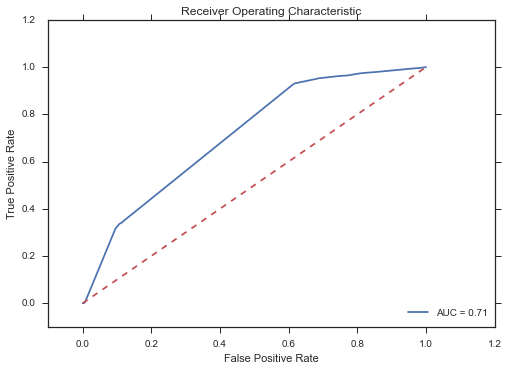

In [133]:
####################################################################################
##Throw all data to Decision Tree for Variable Importance
####################################################################################
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best',max_depth=6)
#clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=4, min_samples_split=100, min_samples_leaf=50)
clf.fit(X_train,Y_train)
print "Train Score: ",clf.score(X_train,Y_train)
print "Test Score: ",clf.score(X_test,Y_test)


print "Classes Predicted: ",clf.classes_
print "Decision Tree Model Score: ",clf.score(X_train, Y_train)
print "\n Accuracy Score:\n", metrics.accuracy_score(Y_test, clf.predict(X_test))
print "\n Confusion Matrix:\n",metrics.confusion_matrix(Y_test, clf.predict(X_test))
print "\n Classification Report:\n",metrics.classification_report(Y_test, clf.predict(X_test))

feature_importances = sorted(zip(X_train.columns,clf.feature_importances_),key=lambda x : x[1],reverse=True)
for feature in feature_importances:
    if feature[1]>0.0001:
        print feature[0] + ': %0.3f' % feature[1]

# generate class probabilities
probs = clf.predict_proba(X_test)
#print probs[:,1:2]

# generate evaluation metrics
from sklearn import metrics


predicted = clf.predict(X_test)
print metrics.accuracy_score(Y_test, predicted)
#print metrics.roc_auc_score(Y_test, probs[:, 1])
#metrics.roc_auc_score(Y_test,predicted)
false_positive_rate, true_positive_rate, thresholds=metrics.roc_curve(Y_test, probs[:,:1],pos_label='no')
print false_positive_rate.shape, false_positive_rate.shape
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [140]:
####################################################################################
#Create a resampled dataframe which contains balanced target
####################################################################################
bank_subset_no_only=bank_telemarket_df_dummified[bank_telemarket_df_dummified.Response=='no']
#print bank_subset_no_only.Response.value_counts()
#bank_subset_no_only.ix[np.random.choice(bank_subset_no_only.index, 10)].count()
bank_subset_no_only_sample=bank_subset_no_only.ix[np.random.choice(bank_subset_no_only.index,6000)]
bank_subset_no_only_sample.describe()

bank_subset_resample_df=bank_subset_no_only_sample.append(
    bank_telemarket_df_dummified[bank_telemarket_df_dummified.Response=='yes'])

bank_subset_resample_df['Response'].value_counts()

####################################################################################
#  TO BE USED TO TRAIN THE MODEL - bank_subset_resample_df
####################################################################################


no     6000
yes    5289
dtype: int64

In [141]:
####################################################################################
##  CREATE X_Train and Test for Under sampled data
####################################################################################

from sklearn.cross_validation import train_test_split
#df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

#features = [col for col in bank_subset_resample_df.columns
#            if col not in ['duration','Response','success','failure']]
features=['success','age','contacted_last_200_days','middle to late of month','jun','mar','divorced','retired']
#removed campaign, balance
print features
Y=bank_subset_resample_df['Response']
#X=bank_telemarket_df.ix[:,:-1]
X=bank_subset_resample_df[features]

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.33)

print len(X_train),len(X_test)


['success', 'age', 'contacted_last_200_days', 'middle to late of month', 'jun', 'mar', 'divorced', 'retired']
7563 3726


In [142]:
####################################################################################
##  Fit a Logistic Regression on a Undersampled Data
##  
####################################################################################


log_model=LogisticRegression()
log_model.fit(X_train,Y_train)
pd.DataFrame(log_model.predict(X_test),Y_test)
# check the accuracy on the training set
print "Classes Predicted: ",log_model.classes_
print "Logistic Regression Model Score: ",log_model.score(X_train, Y_train)
print "\n Accuracy Score:\n", metrics.accuracy_score(Y_test, log_model.predict(X_test))
print "\n Confusion Matrix:\n",metrics.confusion_matrix(Y_test, log_model.predict(X_test))
print "\n Classification Report:\n",metrics.classification_report(Y_test, log_model.predict(X_test))
pd.DataFrame(zip(X_train.columns, np.transpose(log_model.coef_)),columns=["Feature Name","Coefficient"])


Classes Predicted:  ['no' 'yes']
Logistic Regression Model Score:  0.640883247389

 Accuracy Score:
0.659151905529

 Confusion Matrix:
[[1819  198]
 [1072  637]]

 Classification Report:
             precision    recall  f1-score   support

         no       0.63      0.90      0.74      2017
        yes       0.76      0.37      0.50      1709

avg / total       0.69      0.66      0.63      3726



,Feature Name,Coefficient
0,success,[2.47284972215]
1,age,[-0.00993214021671]
2,contacted_last_200_days,[0.616043021458]
3,middle to late of month,[-0.379786570544]
4,jun,[-0.0799526120413]
5,mar,[1.89166208935]
6,divorced,[0.145830460672]
7,retired,[0.903470224936]


['no' 'yes']
0.659151905529
(698L,) (698L,)


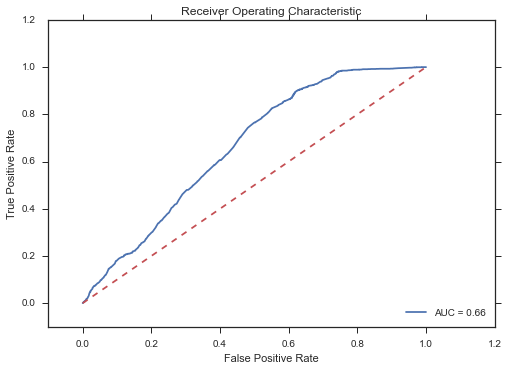

In [143]:
print log_model.classes_
# predict class labels for the test set
predicted = log_model.predict(X_test)
#print log_model.decision_function(X_test) #Log Odds
# generate class probabilities
probs = log_model.predict_proba(X_test)
#print probs[:,1:2]

# generate evaluation metrics
from sklearn import metrics


print metrics.accuracy_score(Y_test, predicted)
#print metrics.roc_auc_score(Y_test, probs[:, 1])
#metrics.roc_auc_score(Y_test,predicted)
false_positive_rate, true_positive_rate, thresholds=metrics.roc_curve(Y_test, probs[:,:1],pos_label='no')
print false_positive_rate.shape, false_positive_rate.shape
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Train Score:  0.665873330689
Test Score:  0.674181427805
Classes Predicted:  ['no' 'yes']
Decision Tree Model Score:  0.665873330689

 Accuracy Score:
0.674181427805

 Confusion Matrix:
[[1827  190]
 [1024  685]]

 Classification Report:
             precision    recall  f1-score   support

         no       0.64      0.91      0.75      2017
        yes       0.78      0.40      0.53      1709

avg / total       0.71      0.67      0.65      3726

success: 0.535
age: 0.271
mar: 0.086
middle to late of month: 0.055
contacted_last_200_days: 0.052
jun: 0.001
0.674181427805
(31L,) (31L,)


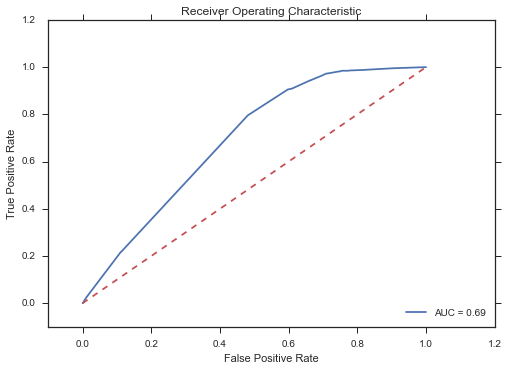

In [144]:
####################################################################################
##Throw all data to Decision Tree for Variable Importance
####################################################################################
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best',max_depth=6)
#clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=4, min_samples_split=100, min_samples_leaf=50)
clf.fit(X_train,Y_train)
print "Train Score: ",clf.score(X_train,Y_train)
print "Test Score: ",clf.score(X_test,Y_test)


print "Classes Predicted: ",clf.classes_
print "Decision Tree Model Score: ",clf.score(X_train, Y_train)
print "\n Accuracy Score:\n", metrics.accuracy_score(Y_test, clf.predict(X_test))
print "\n Confusion Matrix:\n",metrics.confusion_matrix(Y_test, clf.predict(X_test))
print "\n Classification Report:\n",metrics.classification_report(Y_test, clf.predict(X_test))

feature_importances = sorted(zip(X_train.columns,clf.feature_importances_),key=lambda x : x[1],reverse=True)
for feature in feature_importances:
    if feature[1]>0.0001:
        print feature[0] + ': %0.3f' % feature[1]

# generate class probabilities
probs = clf.predict_proba(X_test)
#print probs[:,1:2]

# generate evaluation metrics
from sklearn import metrics


predicted = clf.predict(X_test)
print metrics.accuracy_score(Y_test, predicted)
#print metrics.roc_auc_score(Y_test, probs[:, 1])
#metrics.roc_auc_score(Y_test,predicted)
false_positive_rate, true_positive_rate, thresholds=metrics.roc_curve(Y_test, probs[:,:1],pos_label='no')
print false_positive_rate.shape, false_positive_rate.shape
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

(7563, 8) (3726, 8)
KNN (n=1) accuracy: 0.6004
KNN (n=2) accuracy: 0.6283
KNN (n=3) accuracy: 0.6041
KNN (n=4) accuracy: 0.6186
KNN (n=5) accuracy: 0.5966
KNN (n=6) accuracy: 0.6280
KNN (n=7) accuracy: 0.6090
KNN (n=8) accuracy: 0.6253
KNN (n=9) accuracy: 0.6245
KNN (n=10) accuracy: 0.6417
KNN (n=11) accuracy: 0.6404
KNN (n=12) accuracy: 0.6430
KNN (n=13) accuracy: 0.6433
KNN (n=14) accuracy: 0.6430
KNN (n=15) accuracy: 0.6379
KNN (n=16) accuracy: 0.6530
KNN (n=17) accuracy: 0.6527
KNN (n=18) accuracy: 0.6514
KNN (n=19) accuracy: 0.6559
KNN (n=20) accuracy: 0.6506
KNN (n=21) accuracy: 0.6541
KNN (n=22) accuracy: 0.6479
KNN (n=23) accuracy: 0.6490
KNN (n=24) accuracy: 0.6508
KNN (n=25) accuracy: 0.6476
KNN (n=26) accuracy: 0.6476
KNN (n=27) accuracy: 0.6535
KNN (n=28) accuracy: 0.6506
KNN (n=29) accuracy: 0.6425
KNN (n=30) accuracy: 0.6522
KNN (n=31) accuracy: 0.6551
KNN (n=32) accuracy: 0.6535
KNN (n=33) accuracy: 0.6578
KNN (n=34) accuracy: 0.6557
KNN (n=35) accuracy: 0.6532
KNN (n=36

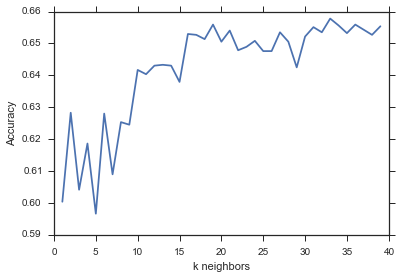

In [150]:
print X_train.shape,X_test.shape
accs = []
for n in range(1,40):
    model = KNeighborsClassifier(n_neighbors=n).fit(X_train,Y_train)
    Y_test_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(Y_test, Y_test_pred)
    accs.append(accuracy)
    print 'KNN (n=%i) accuracy: %.4f' % (n,accuracy)

print 'KNN max accuracy: %.4f' % max(accs)
plt.plot(range(1,40), accs)
plt.xlabel('k neighbors')
plt.ylabel('Accuracy')

In [153]:
print X_train.shape,X_test.shape
n=18
model = KNeighborsClassifier(n_neighbors=n).fit(X_train,Y_train)
Y_test_pred = model.predict(X_test)
accuracy = metrics.accuracy_score(Y_test, Y_test_pred)
accs.append(accuracy)
print 'KNN (n=%i) accuracy: %.4f' % (n,accuracy)

(7563, 8) (3726, 8)
KNN (n=18) accuracy: 0.6514


Train Score:  0.658468861563
Test Score:  0.651368760064
Classes Predicted:  ['no' 'yes']
KNN Model Score:  0.658468861563

 Accuracy Score:
0.651368760064

 Confusion Matrix:
[[1822  195]
 [1104  605]]

 Classification Report:
             precision    recall  f1-score   support

         no       0.62      0.90      0.74      2017
        yes       0.76      0.35      0.48      1709

avg / total       0.68      0.65      0.62      3726

0.651368760064
(18L,) (18L,)


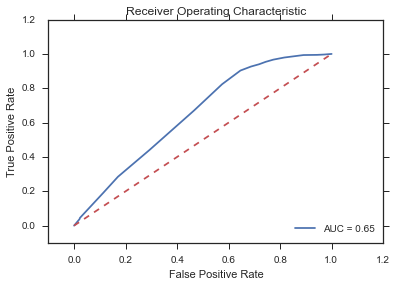

In [155]:
####################################################################################
##
####################################################################################
model.fit(X_train,Y_train)
print "Train Score: ",model.score(X_train,Y_train)
print "Test Score: ",model.score(X_test,Y_test)


print "Classes Predicted: ",model.classes_
print "KNN Model Score: ",model.score(X_train, Y_train)
print "\n Accuracy Score:\n", metrics.accuracy_score(Y_test, model.predict(X_test))
print "\n Confusion Matrix:\n",metrics.confusion_matrix(Y_test, model.predict(X_test))
print "\n Classification Report:\n",metrics.classification_report(Y_test, model.predict(X_test))

# generate class probabilities
probs = model.predict_proba(X_test)
#print probs[:,1:2]

# generate evaluation metrics
from sklearn import metrics


predicted = model.predict(X_test)
print metrics.accuracy_score(Y_test, predicted)
#print metrics.roc_auc_score(Y_test, probs[:, 1])
#metrics.roc_auc_score(Y_test,predicted)
false_positive_rate, true_positive_rate, thresholds=metrics.roc_curve(Y_test, probs[:,:1],pos_label='no')
print false_positive_rate.shape, false_positive_rate.shape
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [39]:
#from sklearn.feature_extraction import DictVectorizer as DV
#vectorizer = DV( sparse = False )
#vec_x_cat_train = vectorizer.fit_transform( bank_telemarket_df.marital )
#vec_x_cat_test = vectorizer.transform( x_cat_test ) 

In [46]:
def create_dummy(df,df_col):
    df_col_dummy=pd.get_dummies(df[df_col])
    df=pd.concat([df,df_col_dummy],axis=1)
    df=df.rename(columns={'yes':df_col+'_yes'})
    df=df.rename(columns={'no':df_col+'_no'})
    df=df.rename(columns={'unknown':df_col+'_unknown'})
    return df

bank_telemarket_df_dummy=create_dummy(bank_telemarket_df,'default')